In [114]:
# imports
import pandas as pd
import numpy as np
from scipy.stats import binom, ttest_ind, chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
# helpers
df_to_list  = lambda df, i: df.iloc[i][df.iloc[i].notnull()].tolist()                   # convert pandas row with nan to list without
remove_nan  = lambda df, i: list(map(lambda x: int(float(x)), df_to_list(df, i)))       # the pandas data frame is a parallogram with nan values as padding 
significant = lambda p_val, alpha: f"Significant: {'yes' if p_val < alpha else 'no'}\n" # finding significant?
round_p_val = lambda p_val: f"p-value:     {round(p_val, 5)}\n"                         # round p value
out_string  = lambda p, a, t: f"{significant(p, a)}{round_p_val(p)}Threshold:  {t}\n"   # format outstring
#bootstrap   = lambda X: np.random.choice(len(X), len(X), replace=True)                  # sample with replacement

In [117]:
days = 7
file = 'data.csv'

In [118]:
df = pd.read_csv(file)              # read constructed data.csv file
df = df[df.columns[1:days + 7 + 2]][:150*days]   # limit to treatment and date columns
df = df[(df != 'forbidden').all(1)] # remove treatment samples that broke due to lacking upvote rights
df = df[df['treatment'] != -1]      # remove treatment samples that were deleted before we could upvote

In [119]:
M = np.array([remove_nan(df, i) for i in range(df.shape[0])]) # convert pandas data frame to numpy array
T = (M[M[:, 0] == 1] - 2)[:, 1:]                              # treatment dataframe with our's and author's upvote REMOVED
C = (M[M[:, 0] == 0] - 1)[:, 1:]                              # control data frame with author's upvote removed

In [120]:
threshs = [10 ** i for i in range(4)] # our hypothesis looks at the four different orders of magnitude
alpha   = 0.05 / (len(threshs))       # significance level with bernferoni correction

In [121]:
for thresh in threshs:
    n_T = T[:,-1].shape[0]
    wins_T =  np.sum(T[:,-1]>= thresh)
    loss_T = n_T - wins_T
    n_C = C[:,-1].shape[0]
    wins_C =  np.sum(C[:,-1]>= thresh)
    loss_C = n_C - wins_C
    tmp = np.array([[loss_T, wins_T], [loss_C, wins_C]])
    p_value = chi2_contingency(tmp)[1]
    
    print(out_string(p_value, alpha, thresh))

Significant: no
p-value:     0.68123
Threshold:  1

Significant: no
p-value:     0.01313
Threshold:  10

Significant: no
p-value:     0.3885
Threshold:  100

Significant: no
p-value:     0.08622
Threshold:  1000



In [122]:
def non_parametric_bootstrap(x, f, nsim=10000, **kwargs):
    """
    Params:
    x  - data (numpy array)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, x.shape[0], x.shape[0])
        X = x[indices]
        #X += np.random.normal(0, 0.05, x.shape[0])
        statistic[i] = f(X, **kwargs)
    
    return statistic

In [123]:
meanT = non_parametric_bootstrap(T[:,-1], np.mean)
meanC = non_parametric_bootstrap(C[:,-1], np.mean)

/home/viktor/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/viktor/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


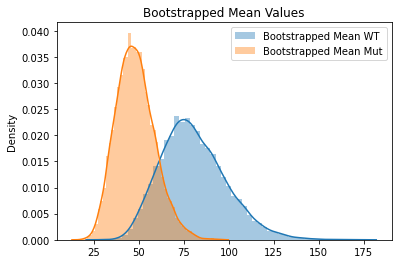

In [124]:
sns.distplot(meanT, label='Bootstrapped Mean WT')
sns.distplot(meanC, label='Bootstrapped Mean Mut')
# plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
# plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
# plt.xlabel('$-\log_{10}{p}$')
#p#lt.ylabel('Probability Density')
plt.title('Bootstrapped Mean Values')
plt.legend()

In [112]:
pvalue = mannwhitneyu(T[:,-1], C[:,-1])[1]
print(pvalue)

0.651076459593726


In [135]:
def difference_of_means(x, y):
    """Calculate the difference in the means of two datasets x and y. Returns a scalar equal to mean(y) - mean(x)"""
    return np.mean(y) - np.mean(x)

def test_null(x, y, statistic, iters=1000):
    """
    Given two datasets, test a null hypothesis using a permutation test for a given statistic.
    
    Params:
    x, y -- ndarrays, the data
    statistic -- a function of x and y
    iters -- number of times to bootstrap
    
    Ouput:
    a numpy array containing the bootstrapped statistic
    """
    def permute(x, y):
        """Given two datasets, return randomly shuffled versions of them"""
        # concatenate the data
        new = np.concatenate([x, y])
        # shuffle the data
        np.random.shuffle(new)
        # return the permuted data sets:
        return new[:len(x)], new[len(x):]

    # do the bootstrap
    return np.array([statistic(*permute(x, y)) for _ in range(iters)])

In [126]:
chue = C[:,-1]
thue = T[:,-1]

In [136]:
diff = test_null(thue, chue, difference_of_means, iters=10**5)

/home/viktor/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The p-value for these samples is 0.06
We cannot reject the null hypothesis that the means are equal between both samples


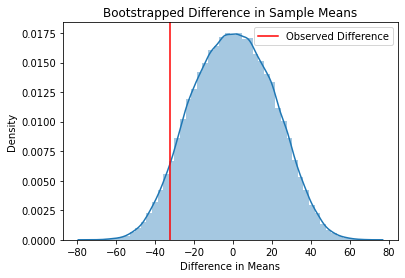

In [137]:
#chue = mt
sns.distplot(diff)
plt.axvline(chue.mean() - thue.mean(), color='red',label='Observed Difference')
plt.title('Bootstrapped Difference in Sample Means')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.legend()

pvalue = len(diff[diff < chue.mean() - thue.mean()])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')

In [138]:
def difference_of_variance(x, y):
    """Calculates the difference in variance between x and y."""
    
    return np.std(y)**2 - np.std(x)**2


diff_vars = test_null(thue - thue.mean(), chue - chue.mean(), difference_of_variance, iters=10**5)

/home/viktor/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The p-value for these samples is 0.78
We cannot reject the null hypothesis that the means are equal between both samples


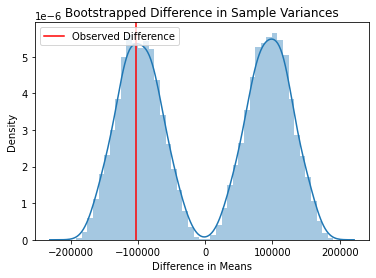

In [139]:
sns.distplot(diff_vars)
plt.axvline(chue.std()**2 - thue.std()**2, color='red',label='Observed Difference')
plt.title('Bootstrapped Difference in Sample Variances')
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.legend()

pvalue = len(diff_vars[diff_vars > chue.std()**2 - thue.std()**2])/len(diff)

print('The p-value for these samples is {0:.2g}'.format(pvalue))
if pvalue < 0.05:
    print('We can reject the null hypothesis that the means are equal between both samples')
else:
    print('We cannot reject the null hypothesis that the means are equal between both samples')